In [61]:
import pandas as pd
import os, sys
import re
import json
import glob
import datetime
from collections import Counter
from pprint import pprint

import nltk

nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud

import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ok\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
#lets get started by importing the new data
data = pd.read_csv('C:/Users/ok/Desktop/Week_0/week-0/data/all_data.csv', encoding='utf-8')


In [63]:
#copy the message got further cleaning
data['cleaned'] = data['msg_content']

In [64]:
def data_preprocessor(data):
    
    #this function preprocesses the given data's message and create a new column 'cleaned' for topic and sentiment analysis
    data['cleaned'] = data['cleaned'].astype(str) #convertt to string
    data['cleaned'] = data['cleaned'].apply(lambda x: x.lower()) #convert to lower case
    data['cleaned'] = data['cleaned'].apply(lambda x: re.sub(r'http\S+', '', x)) # to remove links
    data['cleaned']= data['cleaned'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation))) #remove punctuations
    data['cleaned'] = data['cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) #remove stopwords
    data['cleaned'] = data['cleaned'].apply(lambda x: ' '.join([word for word in x.split() if len(word)>3])) #remove words with length less than 3
    data['cleaned'] = data['cleaned'].apply(lambda x: re.sub(r'\d+', '', x))
    
    return data

def features(data):

    #this function changes sentences into list of words
    messages = [mess for mess in data['cleaned']]
    words = [mess.split() for mess in messages]

    #create dictionalry that containd ID and words 
    word_to_id = corpora.Dictionary(words) #generate unique tokens
    #  we can see the word to unique integer mapping
    # print(word_to_id.token2id)
    # using bag of words(bow), we create a corpus that contains the word id and its frequency in each document.
    corpus_1= [word_to_id.doc2bow(word) for word in words]
    # TFIDF

    return data,words, word_to_id, corpus_1


In [65]:
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [66]:
#clean the message content
data1 = data_preprocessor(data)

In [67]:
#process the cleaned data into features
data2 = features(data1)
data, words, word2id, corous = data2

In [68]:
id_words = [[(word2id[id], count) for id, count in line] for line in corous]

In [69]:
 # Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corous,
                                           id2word=word2id,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [70]:
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('sure', 0.05363646),
   ('yeah', 0.03997876),
   ('great', 0.03761701),
   ('thank', 0.0351995),
   ('make', 0.03473493),
   ('discuss', 0.024230052),
   ('name', 0.018941192),
   ('help', 0.018417008),
   ('really', 0.018008031),
   ('said', 0.01777523)]),
 (1,
  [('thanks', 0.098604485),
   ('uujgrne', 0.068700455),
   ('rollingonthefloorlaughing', 0.053840216),
   ('alright', 0.04309976),
   ('uuvhcvkb', 0.042423088),
   ('uugsfhgt', 0.034693744),
   ('session', 0.031234324),
   ('waiting', 0.022629106),
   ('remote', 0.021937618),
   ('docker', 0.021852946)]),
 (2,
  [('time', 0.1084932),
   ('tasks', 0.037479963),
   ('lets', 0.033702552),
   ('document', 0.033191226),
   ('trying', 0.029549163),
   ('tried', 0.029478097),
   ('today', 0.028099302),
   ('meet', 0.027645221),
   ('anyone', 0.024822209),
   ('report', 0.024232106)]),
 (3,
  [('please', 0.05068059),
   ('group', 0.04018359),
   ('join', 0.027909031),
   ('uuura', 0.024426322),
   ('thats', 0.024313599),
   (

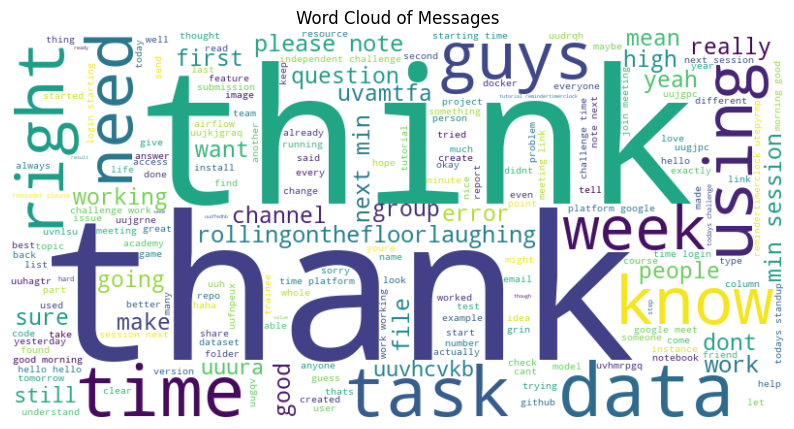

In [71]:
data['msg_sent_time'] = pd.to_datetime(data['msg_sent_time'])
import matplotlib.pyplot as plt

# Group messages by date and concatenate them into a single string for each date
grouped = data.groupby(data['msg_sent_time'].dt.date)['cleaned'].apply(' '.join).reset_index()

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join(grouped['cleaned']))

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Messages')
plt.show()